In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import glob

# Function to analyze the all_burst_labels.json file
def analyze_burst_labels(json_path):
    """
    Analyze the all_burst_labels.json file to find valid/invalid labels
    
    Args:
        json_path: Path to the all_burst_labels.json file
        
    Returns:
        valid_data: List of items with valid labels
        invalid_data: List of items with invalid labels
    """
    with open(json_path, 'r') as f:
        all_data = json.load(f)
    
    valid_data = []
    invalid_data = []
    
    for item in all_data:
        if item.get('has_valid_label', False):
            valid_data.append(item)
        else:
            invalid_data.append(item)
    
    print(f"Total items: {len(all_data)}")
    print(f"Items with valid labels: {len(valid_data)}")
    print(f"Items without valid labels: {len(invalid_data)}")
    
    return valid_data, invalid_data

# Dataset class using NPZ files directly
class EMGDataset(Dataset):
    """Dataset for EMG signals with onset/offset labels"""
    
    def __init__(self, data_items, transform=None):
        """
        Args:
            data_items: List of dictionaries with npz_path and json_path
            transform: Optional transform to apply to the data
        """
        self.data_items = data_items
        self.transform = transform
        
        # Default signal length
        self.signal_length = 435  # Standard epoch length
        
        print(f"Dataset created with {len(data_items)} items")
    
    def __len__(self):
        return len(self.data_items)
    
    def __getitem__(self, idx):
        item = self.data_items[idx]
        
        # Get file paths
        npz_path = item['npz_path']
        json_path = item['json_path']
        
        # Extract filename for plotting
        filename = os.path.basename(npz_path).split('_emg.npz')[0]
        
        # Try to load the signal data
        try:
            data = np.load(npz_path, allow_pickle=True)
            
            # Access signal data following the working approach
            signal_dict = data["signal"].item()  # Convert to dictionary
            signal = signal_dict["signal"]
            
            # Make sure signal is a numpy array of float32
            signal = np.asarray(signal, dtype=np.float32)
            
            # If signal is not the right shape, resize it
            if len(signal) != self.signal_length:
                temp_signal = np.zeros(self.signal_length, dtype=np.float32)
                copy_length = min(len(signal), self.signal_length)
                temp_signal[:copy_length] = signal[:copy_length]
                signal = temp_signal
                
        except Exception as e:
            print(f"Error loading signal from {npz_path}: {e}")
            # If we can't load the signal, use zeros
            signal = np.zeros(self.signal_length, dtype=np.float32)
        
        # Create binary mask (0 = no activity, 1 = activity)
        mask = np.zeros(self.signal_length, dtype=np.float32)
        
        # Load label data if available
        if item.get('has_valid_label', False):
            try:
                with open(json_path, 'r') as f:
                    label_data = json.load(f)
                
                # Check for onset/offset directly in the label_data
                onset = label_data.get('onset')
                offset = label_data.get('offset')
                
                if onset is not None and offset is not None:
                    # Make sure onset/offset are within valid range
                    if 0 <= onset < self.signal_length and 0 <= offset < self.signal_length:
                        mask[onset:offset+1] = 1.0
            except Exception as e:
                print(f"Error loading label from {json_path}: {e}")
                # If we can't load the labels, keep zeros
                pass
        
        # Apply any transformations
        if self.transform:
            signal = self.transform(signal)
        
        return signal, mask, filename
class SignalNormalize:
    """Transform for normalizing EMG signals to 0-1 range"""
    def __call__(self, signal):
        # Min-Max normalization
        signal_min = np.min(signal)
        signal_max = np.max(signal)
        
        # Check if the signal has variation
        if signal_max > signal_min:
            normalized = (signal - signal_min) / (signal_max - signal_min)
            return normalized
        return signal

# Custom collate function to handle metadata dictionary
def custom_collate_fn(batch):
    signals = []
    masks = []
    filenames = []
    
    for signal, mask, filename in batch:
        signals.append(signal)
        masks.append(mask)
        filenames.append(filename)
    
    # Convert to tensors
    signals = torch.tensor(np.array(signals), dtype=torch.float32)
    masks = torch.tensor(np.array(masks), dtype=torch.float32)
    
    return signals, masks, filenames

# Visualize samples from dataset
def visualize_samples(dataset, num_samples=5, output_dir="./", title="Dataset Samples"):
    """Visualize samples from the dataset"""
    num_samples = min(num_samples, len(dataset))
    
    if num_samples <= 0:
        print("No samples to visualize")
        return
    
    plt.figure(figsize=(15, 4 * num_samples))
    
    for i in range(num_samples):
        try:
            signal, mask, filename = dataset[i]
            
            # Create time vector (in milliseconds for better readability)
            time_ms = np.arange(len(signal)) / 2  # 2000 Hz = 0.5 ms per sample
            
            plt.subplot(num_samples, 1, i+1)
            
            # Plot signal
            plt.plot(time_ms, signal, 'b-', alpha=0.5, label='Signal')
            
            # Plot mask on top
            plt.plot(time_ms, mask, 'g-', linewidth=2, label='Label')
            
            # Find onset/offset from mask
            changes = np.diff(np.concatenate([[0], mask, [0]]))
            onsets = np.where(changes == 1)[0]
            offsets = np.where(changes == -1)[0] - 1
            
            # Mark regions and add timestamp annotations
            for j in range(len(onsets)):
                if j < len(offsets):
                    onset_ms = time_ms[onsets[j]]
                    offset_ms = time_ms[offsets[j]]
                    
                    plt.axvspan(onset_ms, offset_ms,
                              color='g', alpha=0.2, 
                              label=f'Activity: {onset_ms:.1f}-{offset_ms:.1f} ms' if j == 0 else None)
            
            plt.title(f'Sample {i+1}: {filename}')
            plt.xlabel('Time (ms)')
            plt.ylabel('Amplitude')
            plt.grid(True)
            plt.legend()
        except Exception as e:
            print(f"Error visualizing sample {i}: {e}")
            continue
    
    plt.tight_layout()
    
    # Save figure
    try:
        output_file = os.path.join(output_dir, f'{title.replace(" ", "_").lower()}.png')
        plt.savefig(output_file)
        print(f"Visualized {num_samples} samples and saved to {output_file}")
    except Exception as e:
        print(f"Error saving visualization: {e}")
    
    plt.show()

# Rest of the code from previous examples (EMGBurstDetector model, training functions, etc.)

In [2]:
# Model definition
class EMGBurstDetector(nn.Module):
    def __init__(self, input_size, hidden_dims=[32, 64, 32], dropout_rate=0.3):
        super(EMGBurstDetector, self).__init__()
        
        self.input_size = input_size
        
        # 1D Convolutional layers for feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, hidden_dims[0], kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hidden_dims[0], hidden_dims[1], kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(hidden_dims[1], hidden_dims[2], kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dims[2]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Final layer
        self.final_layer = nn.Sequential(
            nn.Conv1d(hidden_dims[2], 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape input for 1D convolution [batch, channels, length]
        x = x.view(batch_size, 1, -1)
        
        # Forward through convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Final layer
        x = self.final_layer(x)
        
        # Reshape to match target dimensions [batch, length]
        return x.view(batch_size, -1)

# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=25):
    """Train the model without validation"""
    since = time.time()
    
    # For plotting
    train_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        
        # Iterate over data
        for inputs, labels, _ in tqdm(train_loader, desc=f"Training batches"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        print(f'Training Loss: {epoch_loss:.4f}')
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'training_curve.png'))
    plt.close()
    
    return model, {'train_losses': train_losses}

# Evaluation function
def evaluate_model(model, test_loader, device, output_dir, fs=2000):
    """Evaluate the model on test data and save simple plots with just signal and highlighted prediction areas"""
    # Create predictions directory
    predictions_dir = os.path.join(output_dir, 'predictions')
    os.makedirs(predictions_dir, exist_ok=True)
    
    # Set model to evaluation mode
    model.eval()
    
    # Store all results
    all_results = []
    
    with torch.no_grad():
        for inputs, labels, filenames in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            
            # Forward pass
            predictions = model(inputs)
            
            # Process each sample in the batch
            for i in range(inputs.size(0)):
                signal = inputs[i].cpu().numpy()
                pred = predictions[i].cpu().numpy()
                filename = filenames[i]
                
                # Create binary prediction (threshold at 0.5)
                binary_pred = (pred > 0.5).astype(float)
                
                # Find onset/offset from prediction
                changes = np.diff(np.concatenate([[0], binary_pred, [0]]))
                pred_onsets = np.where(changes == 1)[0]
                pred_offsets = np.where(changes == -1)[0] - 1
                
                # Create time vector
                time = np.arange(len(signal)) / fs
                
                # Create a very simple plot - just signal with highlighted predicted areas
                plt.figure(figsize=(10, 3))
                
                # Plot signal
                plt.plot(time, signal, 'k-', linewidth=1)
                
                # Highlight predicted areas only
                for j in range(len(pred_onsets)):
                    if j < len(pred_offsets):
                        plt.axvspan(time[pred_onsets[j]], time[pred_offsets[j]],
                                  color='orange', alpha=0.3)
                
                plt.title(filename)
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.tight_layout()
                
                # Save the plot
                plot_path = os.path.join(predictions_dir, f'{filename}_prediction.png')
                plt.savefig(plot_path)
                plt.close()
                
                # Store result
                result = {
                    'filename': filename,
                    'pred_onsets': pred_onsets.tolist(),
                    'pred_offsets': pred_offsets.tolist()
                }
                all_results.append(result)
    
    # Save all results to JSON
    results_path = os.path.join(output_dir, 'test_results.json')
    with open(results_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"Evaluation complete. Saved {len(all_results)} minimal prediction plots to {predictions_dir}")
    return all_results

Total items: 1599
Items with valid labels: 644
Items without valid labels: 955
Dataset created with 644 items
Dataset created with 955 items
Visualized 5 samples and saved to C:\EMG_onset_detection\LOL_project\trained_model\training_samples.png


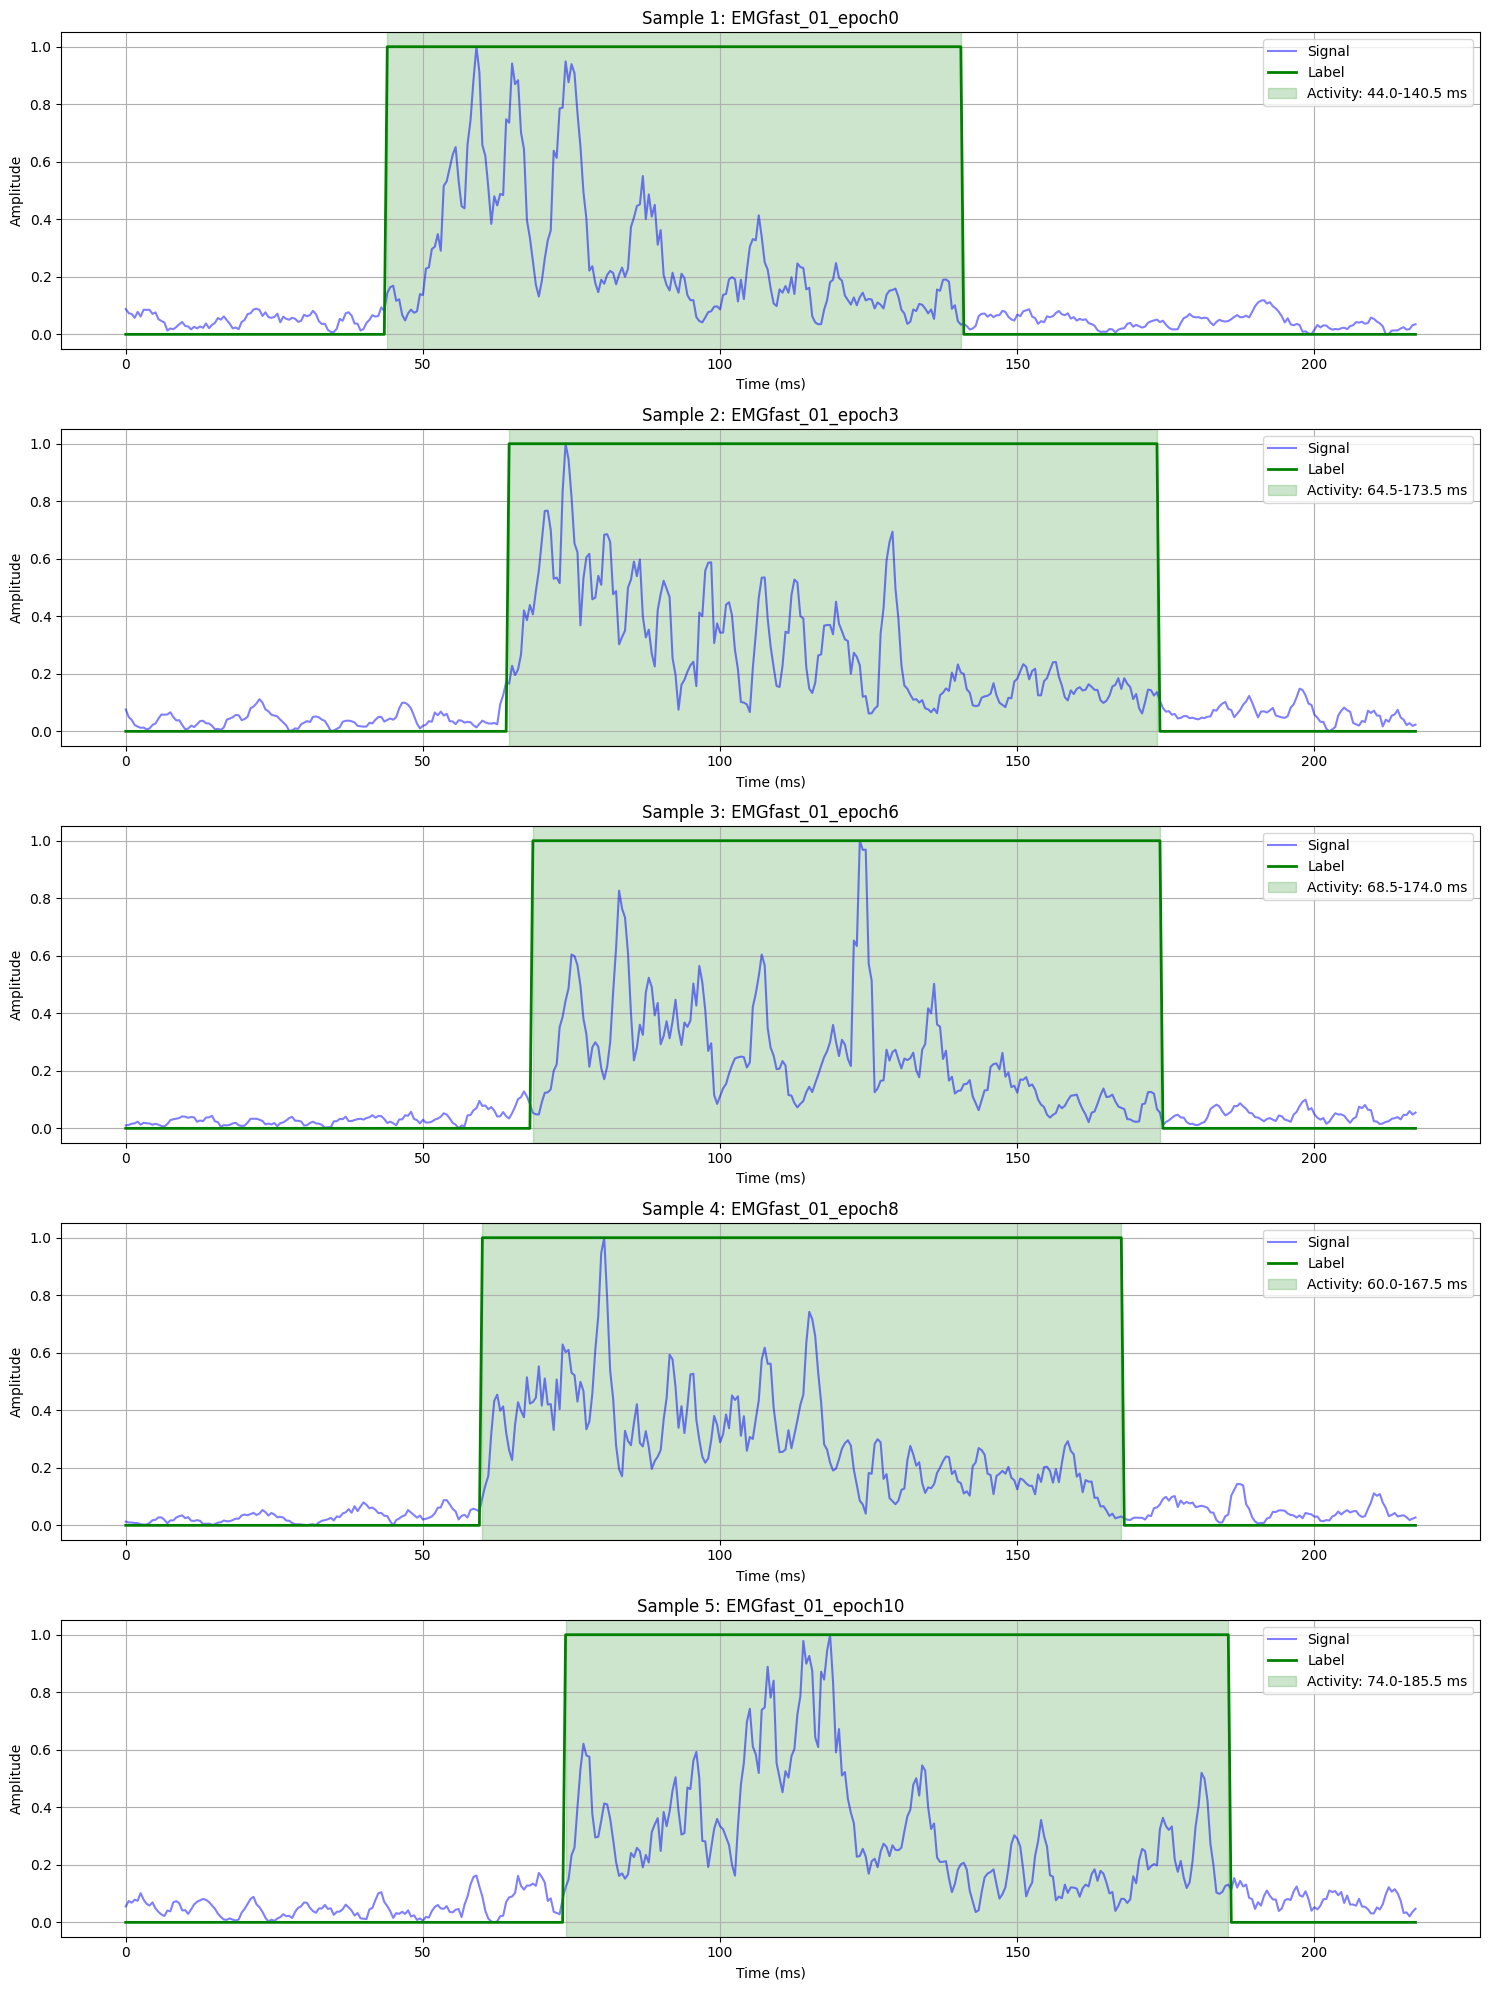

In [4]:
# File paths
json_labels_path = r"C:\EMG_onset_detection\LOL_project\training_data\all_burst_labels.json"
output_dir = r"C:\EMG_onset_detection\LOL_project\trained_model"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Analyze burst labels
valid_data, invalid_data = analyze_burst_labels(json_labels_path)

# Set up datasets
transform = SignalNormalize()

# Create training dataset with valid labels
train_dataset = EMGDataset(valid_data, transform=transform)

# Create test dataset with invalid labels
test_dataset = EMGDataset(invalid_data, transform=transform)

# Visualize 5 training samples
if len(train_dataset) > 0:
    visualize_samples(train_dataset, num_samples=5, output_dir=output_dir, title="Training Samples")

# Visualize 5 test samples
# if len(test_dataset) > 0:
#     visualize_samples(test_dataset, num_samples=5, output_dir=output_dir, title="Test Samples")

In [5]:
# Configure DataLoaders
if len(train_dataset) > 0:
    batch_size = min(32, len(train_dataset))
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        collate_fn=custom_collate_fn
    )
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create model
    input_size = train_dataset.signal_length
    model = EMGBurstDetector(input_size=input_size).to(device)
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    print("Training model...")
    trained_model, loss_history = train_model(
        model, train_loader, criterion, optimizer, device,
        num_epochs=50
    )
    
    # Save the trained model
    model_path = os.path.join(output_dir, 'emg_burst_detector.pt')
    torch.save(trained_model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    # Evaluate on test set if available
    if len(test_dataset) > 0:
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, 
            collate_fn=custom_collate_fn
        )
        
        print("Evaluating model on test set...")
        test_results = evaluate_model(
            trained_model, test_loader, device, output_dir
        )
        
        # Save metadata
        metadata = {
            'input_size': input_size,
            'train_samples': len(train_dataset),
            'test_samples': len(test_dataset),
            'final_train_loss': loss_history['train_losses'][-1] if loss_history['train_losses'] else None,
            'epochs_trained': len(loss_history['train_losses']),
            'date_trained': time.strftime("%Y-%m-%d %H:%M:%S"),
            'sampling_rate': 2000,
            'num_test_predictions': len(test_results)
        }
        
        with open(os.path.join(output_dir, 'model_metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print("Training and evaluation complete!")
        print(f"Prediction images saved to the '{os.path.join(output_dir, 'predictions')}' folder!")
    else:
        print("No test samples available for evaluation.")
else:
    print("No training samples available. Cannot train the model.")

Using device: cpu
Training model...
Epoch 1/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.16it/s]


Training Loss: 0.4195

Epoch 2/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.43it/s]


Training Loss: 0.2958

Epoch 3/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 18.81it/s]


Training Loss: 0.2745

Epoch 4/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.19it/s]


Training Loss: 0.2719

Epoch 5/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.75it/s]


Training Loss: 0.2718

Epoch 6/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.16it/s]


Training Loss: 0.2681

Epoch 7/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.47it/s]


Training Loss: 0.2664

Epoch 8/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.00it/s]


Training Loss: 0.2674

Epoch 9/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.75it/s]


Training Loss: 0.2652

Epoch 10/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.88it/s]


Training Loss: 0.2632

Epoch 11/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.46it/s]


Training Loss: 0.2651

Epoch 12/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Training Loss: 0.2678

Epoch 13/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.09it/s]


Training Loss: 0.2634

Epoch 14/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.50it/s]


Training Loss: 0.2632

Epoch 15/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.55it/s]


Training Loss: 0.2620

Epoch 16/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.19it/s]


Training Loss: 0.2626

Epoch 17/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.65it/s]


Training Loss: 0.2608

Epoch 18/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.23it/s]


Training Loss: 0.2624

Epoch 19/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.98it/s]


Training Loss: 0.2606

Epoch 20/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.20it/s]


Training Loss: 0.2614

Epoch 21/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.57it/s]


Training Loss: 0.2594

Epoch 22/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.20it/s]


Training Loss: 0.2606

Epoch 23/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.60it/s]


Training Loss: 0.2618

Epoch 24/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.15it/s]


Training Loss: 0.2589

Epoch 25/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.68it/s]


Training Loss: 0.2601

Epoch 26/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.20it/s]


Training Loss: 0.2647

Epoch 27/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.03it/s]


Training Loss: 0.2595

Epoch 28/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.31it/s]


Training Loss: 0.2570

Epoch 29/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.21it/s]


Training Loss: 0.2616

Epoch 30/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.77it/s]


Training Loss: 0.2590

Epoch 31/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.62it/s]


Training Loss: 0.2601

Epoch 32/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.63it/s]


Training Loss: 0.2586

Epoch 33/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.27it/s]


Training Loss: 0.2592

Epoch 34/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.29it/s]


Training Loss: 0.2589

Epoch 35/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.11it/s]


Training Loss: 0.2562

Epoch 36/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.46it/s]


Training Loss: 0.2583

Epoch 37/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.59it/s]


Training Loss: 0.2577

Epoch 38/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.62it/s]


Training Loss: 0.2559

Epoch 39/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 17.61it/s]


Training Loss: 0.2601

Epoch 40/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.65it/s]


Training Loss: 0.2577

Epoch 41/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.86it/s]


Training Loss: 0.2577

Epoch 42/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.92it/s]


Training Loss: 0.2559

Epoch 43/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.81it/s]


Training Loss: 0.2584

Epoch 44/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 22.15it/s]


Training Loss: 0.2578

Epoch 45/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.52it/s]


Training Loss: 0.2583

Epoch 46/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.82it/s]


Training Loss: 0.2578

Epoch 47/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.36it/s]


Training Loss: 0.2557

Epoch 48/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.67it/s]


Training Loss: 0.2556

Epoch 49/50
----------


Training batches: 100%|██████████| 21/21 [00:00<00:00, 21.80it/s]


Training Loss: 0.2551

Epoch 50/50
----------


Training batches: 100%|██████████| 21/21 [00:01<00:00, 20.52it/s]


Training Loss: 0.2610

Training complete in 0m 50s
Model saved to C:\EMG_onset_detection\LOL_project\trained_model\emg_burst_detector.pt
Evaluating model on test set...


Evaluating: 100%|██████████| 30/30 [01:41<00:00,  3.39s/it]

Evaluation complete. Saved 955 minimal prediction plots to C:\EMG_onset_detection\LOL_project\trained_model\predictions
Training and evaluation complete!
Prediction images saved to the 'C:\EMG_onset_detection\LOL_project\trained_model\predictions' folder!


Using device: cpu
Found 955 test samples
Dataset created with 955 items
Loaded input_size=435 from metadata
Model loaded from C:\EMG_onset_detection\LOL_project\trained_model\emg_burst_detector.pt


Running predictions:  93%|█████████▎| 28/30 [03:10<00:13,  6.79s/it]


KeyboardInterrupt: 

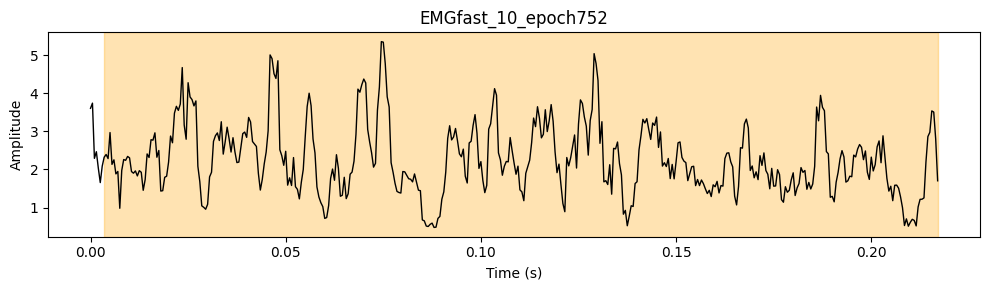

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
from torch.utils.data import DataLoader

# 1. Define the model class (needs to match the saved model architecture)
class EMGBurstDetector(nn.Module):
    def __init__(self, input_size, hidden_dims=[32, 64, 32], dropout_rate=0.3):
        super(EMGBurstDetector, self).__init__()
        
        self.input_size = input_size
        
        # 1D Convolutional layers for feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, hidden_dims[0], kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hidden_dims[0], hidden_dims[1], kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(hidden_dims[1], hidden_dims[2], kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dims[2]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Final layer
        self.final_layer = nn.Sequential(
            nn.Conv1d(hidden_dims[2], 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape input for 1D convolution [batch, channels, length]
        x = x.view(batch_size, 1, -1)
        
        # Forward through convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Final layer
        x = self.final_layer(x)
        
        # Reshape to match target dimensions [batch, length]
        return x.view(batch_size, -1)

# 2. Function to load model and run predictions
def load_model_and_predict(model_path, test_loader, device, output_dir, threshold=0.5, fs=2000):
    """
    Load a trained model and run predictions on test data
    
    Args:
        model_path: Path to the saved model
        test_loader: DataLoader with test data
        device: Device to run model on
        output_dir: Directory to save results
        threshold: Threshold for binary predictions
        fs: Sampling frequency
    """
    # Create predictions directory
    predictions_dir = os.path.join(output_dir, 'predictions')
    os.makedirs(predictions_dir, exist_ok=True)
    
    # Load model metadata if available
    metadata_path = os.path.join(os.path.dirname(model_path), 'model_metadata.json')
    input_size = 435  # Default
    
    if os.path.exists(metadata_path):
        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                input_size = metadata.get('input_size', 435)
                print(f"Loaded input_size={input_size} from metadata")
        except:
            print(f"Could not load metadata from {metadata_path}, using default input_size={input_size}")
    
    # Create model and load weights
    model = EMGBurstDetector(input_size=input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Store all results
    all_results = []
    
    with torch.no_grad():
        for inputs, labels, filenames in tqdm(test_loader, desc="Running predictions"):
            inputs = inputs.to(device)
            
            # Forward pass
            predictions = model(inputs)
            
            # Process each sample in the batch
            for i in range(inputs.size(0)):
                signal = inputs[i].cpu().numpy()
                pred = predictions[i].cpu().numpy()
                filename = filenames[i]
                
                # Create binary prediction (threshold at specified value)
                binary_pred = (pred > threshold).astype(float)
                
                # Find onset/offset from prediction
                changes = np.diff(np.concatenate([[0], binary_pred, [0]]))
                pred_onsets = np.where(changes == 1)[0]
                pred_offsets = np.where(changes == -1)[0] - 1
                
                # Create time vector
                time = np.arange(len(signal)) / fs
                
                # Create a very simple plot - just signal with highlighted predicted areas
                plt.figure(figsize=(10, 3))
                
                # Plot signal
                plt.plot(time, signal, 'k-', linewidth=1)
                
                # Highlight predicted areas only
                for j in range(len(pred_onsets)):
                    if j < len(pred_offsets):
                        plt.axvspan(time[pred_onsets[j]], time[pred_offsets[j]],
                                  color='orange', alpha=0.3)
                
                plt.title(filename)
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.tight_layout()
                
                # Save the plot
                plot_path = os.path.join(predictions_dir, f'{filename}_prediction.png')
                plt.savefig(plot_path)
                plt.close()
                
                # Store result
                result = {
                    'filename': filename,
                    'pred_onsets': pred_onsets.tolist(),
                    'pred_offsets': pred_offsets.tolist()
                }
                all_results.append(result)
    
    # Save all results to JSON
    results_path = os.path.join(output_dir, 'prediction_results.json')
    with open(results_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"Prediction complete. Saved {len(all_results)} minimal prediction plots to {predictions_dir}")
    print(f"Results saved to {results_path}")
    
    return all_results
# 3. Sample usage code
if __name__ == "__main__":
    # Set your paths
    model_path = r"C:\EMG_onset_detection\LOL_project\trained_model\emg_burst_detector.pt"
    output_dir = r"C:\EMG_onset_detection\LOL_project\prediction_results"
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create test dataset and dataloader
    test_data_file = r"C:\EMG_onset_detection\LOL_project\training_data\all_burst_labels.json"
    
    # Load test data
    with open(test_data_file, 'r') as f:
        all_data = json.load(f)
    
    # Filter for unlabeled data (or you could use all data for prediction)
    test_data = [item for item in all_data if not item.get('has_valid_label', False)]
    print(f"Found {len(test_data)} test samples")
    
    # Create test dataset
    transform = SignalNormalize()
    # Create test dataset with invalid labels
    test_dataset = EMGDataset(invalid_data, transform=transform)
    
    # Create test dataloader
    batch_size = 32
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        collate_fn=custom_collate_fn
    )
    
    # Load model and run predictions
    results = load_model_and_predict(model_path, test_loader, device, output_dir)
    
    print("Prediction complete!")